<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/jax_cosmo/blob/master/notebooks/jax-cosmo-intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to jax-cosmo

In [0]:
# Installing jax-cosmo
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/jax_cosmo.git

In [0]:
%pylab inline
import jax
import jax_cosmo as jc
import jax.numpy as np

Populating the interactive namespace from numpy and matplotlib


In [0]:
#@title Defining some plotting functions [run me]

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(hessian, pos,  nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = - hessian
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  vals, vecs = eigsorted(cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  ellip = Ellipse(xy=pos, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[0] - s1, pos[0] + s1)
  ax.set_ylim(pos[1] - s2, pos[1] + s2)
  plt.draw()
  return ellip

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in arange is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in arange is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dt

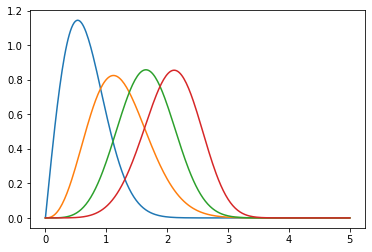

In [0]:
# Let's define a few redshift bins
nz1 = jc.redshift.smail_nz(1., 2., 0.75)
nz2 = jc.redshift.smail_nz(2.5, 2., 1.)
nz3 = jc.redshift.smail_nz(4., 3., 1.5)
nz4 = jc.redshift.smail_nz(5., 4., 2.)

z = np.linspace(0,5,256)
plot(z, nz1(z))
plot(z, nz2(z))
plot(z, nz3(z))
plot(z, nz4(z))

In [0]:
# Get a cosmology
cosmo = jc.Planck15()

lensing_bins = [nz2, nz3, nz4]
clustering_bins = [nz1]

# Define a list of probes
probes = [jc.probes.WeakLensing(lensing_bins),
          jc.probes.NumberCounts(clustering_bins, jc.bias.constant_linear_bias(1.))]

In [0]:
ell = np.logspace(1,3)

# Get some fake observed cls
cls = jc.angular_cl.angular_cl(cosmo, ell, probes) + jc.angular_cl.noise_cl(ell, probes)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in

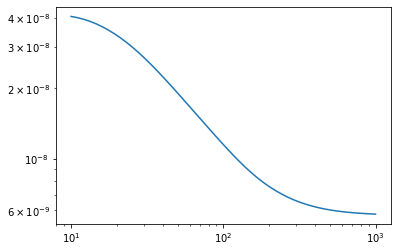

In [0]:
# This is for instance the first bin auto-spectrum 
loglog(ell, cls[0])

In [0]:
# Let's define a parameter vector for Omega_cdm, sigma8
data = cls.flatten();
params = np.array([0.3, 0.8])

@jax.jit
def likelihood(p):
  # Create a cosmology at these parameters
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])

  # Compute mean and covariance of angular Cls
  mu, cov = jc.angular_cl.gaussian_cl_covariance(cosmo, ell, probes)

  # Return likelihood value
  return jc.likelihood.gaussian_log_likelihood(data, mu, cov)

In [0]:
# Computing the likelihood
print(likelihood(params))
%timeit likelihood(params).block_until_ready()

In [0]:
# But wait, there is more! We can compute the derivatives of the likelihood
grad_loglik = jax.jit(jax.grad(likelihood))

In [0]:
print(grad_loglik(params))
%timeit grad_loglik(params).block_until_ready()

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in

[-16757.805   -2661.7798]
1 loop, best of 3: 202 ms per loop


In [0]:
# And now, the killer example! Hessian of the likelihood

In [0]:
hessian_loglik = jax.jit(jax.hessian(likelihood))

In [0]:
H = hessian_loglik(params)
%timeit hess_loglik(params).block_until_ready()

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in

1 loop, best of 3: 687 ms per loop


Text(14.375, 0.5, 'sigma8')

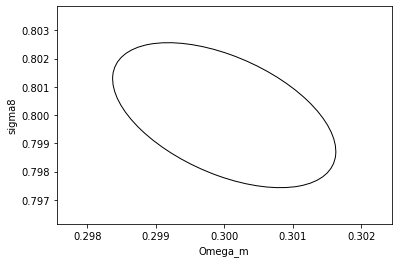

In [0]:
# Let's compute the Fisher matrix, i.e. the same thing but at the true cosmmology
H = hessian_loglik(np.array([cosmo.Omega_c, cosmo.sigma8]))

plot_contours(H, params, fill=False);
xlabel('Omega_m')
ylabel('sigma8')